In [2]:
# initial setup
%run "../../../common/0_notebooks_base_setup.py"


/Users/csuarezgurruchaga/Desktop/Digital-House/CLASE_39/dsad_2021/common
default checking
Running command `conda list`... ok
jupyterlab=2.2.6 already installed
pandas=1.1.5 already installed
bokeh=2.2.3 already installed
seaborn=0.11.0 already installed
matplotlib=3.3.2 already installed
ipywidgets=7.5.1 already installed
pytest=6.2.1 already installed
chardet=4.0.0 already installed
psutil=5.7.2 already installed
scipy=1.5.2 already installed
statsmodels=0.12.1 already installed
scikit-learn=0.23.2 already installed
xlrd=2.0.1 already installed
Running command `conda install --yes nltk=3.5.0`... ok
Solving environment: ...working... done

# All requested packages already installed.


unidecode=1.1.1 already installed
pydotplus=2.0.2 already installed
pandas-datareader=0.9.0 already installed
flask=1.1.2 already installed


---

<img src='../../../common/logo_DH.png' align='left' width=35%/>

# Importancia de features

<a id="section_toc"></a> 

## Tabla de Contenidos

[Intro](#section_intro)

[Dataset](#section_dataset)

[Imports](#section_imports)

[Importancia de features en un Árbol de decisión](#section_feature_importance_tree)

[Importancia de features en modelos de Ensamble](#section_feature_importance_ensamble)


<a id="section_intro"></a> 
## Intro

[volver a TOC](#section_toc)


Como científicos de datos, a menudo nos centramos en optimizar el rendimiento del modelo. 

Sin embargo, a veces eso es tan importante como comprender cómo las features de nuestro modelo contribuyen a la predicción. 

En esta práctica veremos cómo determinar la importancia de features en modelos CART y de ensamble.


<a id="section_dataset"></a> 
## Dataset

[volver a TOC](#section_toc)

Para ejemplificar el cálculo de importancia de features en modeos CART y de ensamble vamos a usar los datos de Car Evaluation Data Set disponibles en 

https://archive.ics.uci.edu/ml/datasets/car+evaluation

https://www.kaggle.com/elikplim/car-evaluation-data-set

La variable target (acceptability) en este dataset tiene cuatro valores posibles:

* unacc
* acc
* good
* vgood

Usando árboles de decisión y ensambles vamos a construir modelos que intenten predecir el valor de acceptability y vamos a evaluar la importancia de las features en cada uno de los modelos construídos

<a id="section_imports"></a> 
## Imports

[volver a TOC](#section_toc)




In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from IPython.display import Image
import pydotplus

Vamos a comenzar con la lectura del dataset de aceptabilidad de autos.

In [4]:
df = pd.read_csv('../Data/car.csv') 
df.head()

,buying,maint,doors,persons,lug_boot,safety,acceptability
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


Los valores posibles de la variable target son 4, cada uno en la siguiente proporción:

In [5]:
df.acceptability.value_counts() / df.shape[0]

unacc    0.700231
acc      0.222222
good     0.039931
vgood    0.037616
Name: acceptability, dtype: float64

Esta vez codificaremos los features usando un esquema de codificación One Hot, es decir, los consideraremos como variables categóricas.

Debido a que Scikit-Learn no entiende los strings, sólo números, también necesitaremos asignarle números a las etiquetas. Para eso usaremos el `LabelEncoder`.

https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

In [6]:
le = LabelEncoder()
y = le.fit_transform(df['acceptability'])
X = pd.get_dummies(df.drop('acceptability', axis=1))
X.head()

,buying_high,buying_low,buying_med,buying_vhigh,maint_high,maint_low,maint_med,maint_vhigh,doors_2,doors_3,...,doors_5more,persons_2,persons_4,persons_more,lug_boot_big,lug_boot_med,lug_boot_small,safety_high,safety_low,safety_med
0,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,0,0,1
2,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0
3,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,1,0,...,0,1,0,0,0,1,0,0,0,1


Vamos a entrenar un árbol de decisión. También vamos a limitar artificialmente el árbol a ser pequeño para que podamos visualizarlo.

In [7]:
# partimos en entrenamiento-prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=41)

<a id="section_feature_importance_tree"></a> 
 ## Importancia de features en un Árbol de decisión

[volver a TOC](#section_toc)

 


In [8]:
dt = DecisionTreeClassifier(max_depth = 3, min_samples_split = 2, random_state = 11)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=3, random_state=11)

Ahora visualicemos el árbol usando el exportador de graphviz.

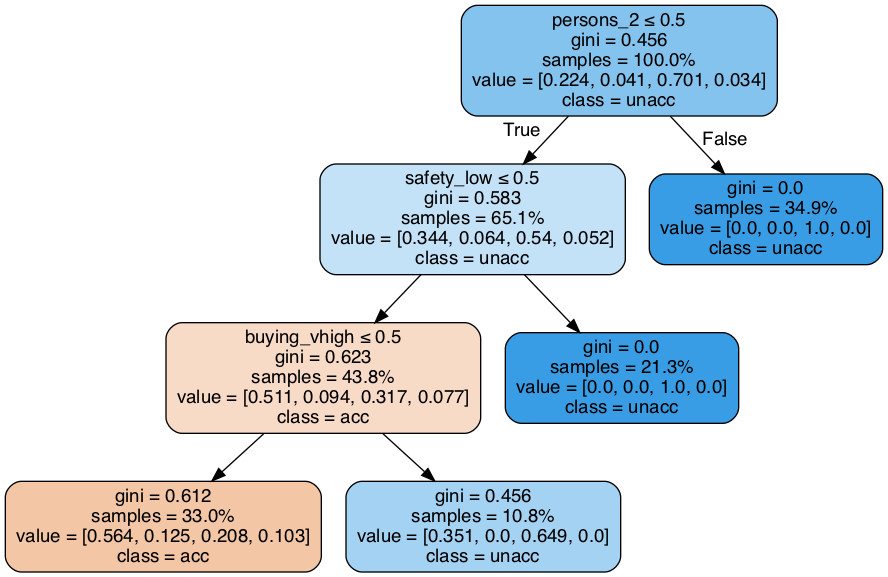

In [9]:
dot_data = export_graphviz(dt, out_file=None,  
                    feature_names=X.columns,  
                    class_names=le.classes_,  
                    filled=True, rounded=True,
                    proportion=True,
                    special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**Veamos qué información nos da este gráfico**

Cada nodo que no es una hoja divide los datos en dos hijos. 

El nodo raíz contiene todos los datos (conjunto de entrenamiento).

**Nodo raíz**:

samples = 100% significa que el nodo contiene el total del conjunto de entrenamiento.

valor = [0.224, 0.041, 0.701, 0.034] son las probabilidades de cada clase (acc, good, unacc, vgood)

class indica la clase con probabilidad máxima en ese nodo (el máximo elemento de valor)

gini = 0.456 es la impureza de gini del nodo. Describe cuánto se mezclan las clases.

persons_2 <= 0.5 significa que el nodo se divide de modo que todas las muestras en las que el valor de persons_2 sea inferior o igual a 0.5 se dirijen al elemento secundario izquierdo y las muestras en las que el valor de la feature es superior a 0.5 se dirijen al elemento secundario derecho.

**Nodos hoja**:

Estos nodos no se dividen más, por lo que no hay necesidad de una condición.

El valor de gini indica el nivel de impurezas restantes en los nodos hoja. Son más bajos que en el nodo padre, lo que significa que la división mejoró la separabilidad entre las clases, pero todavía queda algo de incertidumbre.

**Split**

Los nodos se dividen usando como condición aquella que minimice el promedio pesado de los scores Gini de los nodos hijos.


---

Ahora veamos la importancia de los features del árbol generado.
Para lo cual utilizaremos la property `feature_importances_` de `DecisionTreeClassifier`

https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier.feature_importances_

La importancia de features de `DecisionTreeClassifier` se calcula como la importancia de Gini.


In [10]:
importancia_features = pd.DataFrame(dt.feature_importances_, index = X_train.columns, columns=['importancia'])

importancia_features_sort = importancia_features.sort_values('importancia', ascending=False)

importancia_features_sort[0:5]

,importancia
safety_low,0.519814
persons_2,0.374177
buying_vhigh,0.106010
buying_high,0.000000
doors_5more,0.000000


Verifiquemos que `dt.feature_importances_` nos devuelve la reducción total normalizada, debida a cada feature, del valor de Gini 


In [11]:
ganancia_gini_persons_2    = 1.000 * 0.4576 - 0.651 * 0.583 - 0.349 * 0.0000
ganancia_gini_safety_low   = 0.651 * 0.583 - 0.438 * 0.623 - 0.213 * 0.0000
ganancia_gini_buying_vhigh = 0.438 * 0.623 - 0.333 * 0.612 - 0.108 * 0.456

norm = ganancia_gini_persons_2 + ganancia_gini_safety_low + ganancia_gini_buying_vhigh

print ("persons_2:", ganancia_gini_persons_2 / norm)
print ("safety_low:", ganancia_gini_safety_low / norm)
print ("buying_vhigh:", ganancia_gini_buying_vhigh / norm)

persons_2: 0.38164121316412125
safety_low: 0.5214171180508027
buying_vhigh: 0.09694166878507596


Vemos que la feature de mayor importancia que nos devuelve `feature_importances_` no coincide con el nodo raíz de nuestro modelo, veamos por qué:

Eligiendo como nodo raiz safety_low, la reducción en ese paso es menor que la que obtenemos con persons_2 como raíz

In [12]:
cantidad_ocurrencias_clases = pd.Series(y_train).value_counts()
total_observaciones = sum(cantidad_ocurrencias_clases )

proporciones_clases = cantidad_ocurrencias_clases / total_observaciones

print ("Proporciones Clases")
print (proporciones_clases)

gini_root = 1 - sum( proporciones_clases ** 2 )
print ("Gini root: ", gini_root)


Proporciones Clases
2    0.700579
0    0.224152
1    0.041356
3    0.033912
dtype: float64
Gini root:  0.456084467130653


Calculamos la reducción del valor de Gini que obtenemos usando safety_low <= 0.5

In [13]:
safety_low_mask = X_train.safety_low <= 0.5
#sum(safety_low_mask)

y_train_left = y_train[safety_low_mask]
y_train_right = y_train[np.logical_not(safety_low_mask)]

prop_ocurrencias_clases_left = pd.Series(y_train_left).value_counts() / sum(safety_low_mask)
print("proporciones clases left: \n", prop_ocurrencias_clases_left)

prop_ocurrencias_clases_right = pd.Series(y_train_right).value_counts() / sum(np.logical_not(safety_low_mask))
print("proporciones clases right: \n", prop_ocurrencias_clases_right)

prop_left = sum(safety_low_mask) / len(y_train)
prop_right = sum(np.logical_not(safety_low_mask)) / len(y_train)

print("prop left ", prop_left)
print("prop rigth ",prop_right)

proporciones_clases = cantidad_ocurrencias_clases / total_observaciones

print ("Proporciones Clases")
print (proporciones_clases)

gini_left = 1 - sum( prop_ocurrencias_clases_left ** 2 )
print ("Gini left: ", gini_left)


gini_right = 1 - sum( prop_ocurrencias_clases_right ** 2 )
print ("Gini right: ", gini_right)


ganancia = gini_root - gini_left * prop_left - gini_right * prop_right
print("ganancia safety_low: ", ganancia)

proporciones clases left: 
 2    0.556916
0    0.331701
1    0.061200
3    0.050184
dtype: float64
proporciones clases right: 
 2    1.0
dtype: float64
prop left  0.6757650951199339
prop rigth  0.3242349048800662
Proporciones Clases
2    0.700579
0    0.224152
1    0.041356
3    0.033912
dtype: float64
Gini left:  0.5735555192669841
Gini right:  0.0
ganancia safety_low:  0.0684956670966364


Calculamos la reducción del valor de Gini que obtenemos usando persons_2 <= 0.5

In [14]:
persons2_mask = X_train.persons_2 <= 0.5
#sum(safety_low_mask)

y_train_left = y_train[persons2_mask]
y_train_right = y_train[np.logical_not(persons2_mask)]

prop_ocurrencias_clases_left = pd.Series(y_train_left).value_counts() / sum(persons2_mask)
print("proporciones clases left: \n", prop_ocurrencias_clases_left)

prop_ocurrencias_clases_right = pd.Series(y_train_right).value_counts() / sum(np.logical_not(persons2_mask))
print("proporciones clases right: \n", prop_ocurrencias_clases_right)

prop_left = sum(persons2_mask) / len(y_train)
prop_right = sum(np.logical_not(persons2_mask)) / len(y_train)

print("prop left ", prop_left)
print("prop rigth ",prop_right)

proporciones_clases = cantidad_ocurrencias_clases / total_observaciones

print ("Proporciones Clases")
print (proporciones_clases)

gini_left = 1 - sum( prop_ocurrencias_clases_left ** 2 )
print ("Gini left: ", gini_left)


gini_right = 1 - sum( prop_ocurrencias_clases_right ** 2 )
print ("Gini right: ", gini_right)


ganancia = gini_root - gini_left * prop_left - gini_right * prop_right
print("ganancia persons_2: ", ganancia)

proporciones clases left: 
 2    0.540025
0    0.344346
1    0.063532
3    0.052097
dtype: float64
proporciones clases right: 
 2    1.0
dtype: float64
prop left  0.6509511993382961
prop rigth  0.3490488006617039
Proporciones Clases
2    0.700579
0    0.224152
1    0.041356
3    0.033912
dtype: float64
Gini left:  0.5830482313451271
Gini right:  0.0
ganancia persons_2:  0.07654852166447018


Entonces, vemos que usando la condición safety_low <= 0.5 la reducción es del 6.8% y usando persons_2 <= 0.5 la reducción es del 7.6%

Por eso aunque en `feature_importances_` `safety_low` tiene más importancia que `persons_2`, la segunda produce una ganancia mayor en el primero split y por eso el algoritmo la definió como raiz.

---

<a id="section_feature_importance_ensamble"></a> 
## Importancia de features en modelos de Ensamble

[volver a TOC](#section_toc)


Vamos a construir ahora dos modelos en ensamble para resolver el mismo problema, y calcular la importancia de las features en esos modelos.

Comencemos con con un modelo random forest

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [15]:
rf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_jobs=-1)

Los modelos random forest exponen la importancia de los features que es calculada como la media de la importancia de los features de los árboles base. Vamos a verificar eso.

Podemos acceder a los árboles base que componen el ensamble con  la property `estimators_` 

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

Para calcular la importancia de features de cada uno de los árboles base podemos usar una lista por comprensión:

`[tree.feature_importances_ for tree in rf.estimators_]`

Cada elemento de esta lista es otra lista donde cada uno de sus elementos es la importancia de esa variable en ese árbol.

Vamos a construir un DataFrame que donde cada columna sea una de las variables predictoras de un árbol base, y cada fila sea un árbol base.

Luego, calculamos la media por columna y obtenemos la importancia de cada feature en el modelo de ensamble.

In [16]:
importancias = rf.feature_importances_

trees_feature_importance = [tree.feature_importances_ for tree in rf.estimators_]

print("Cantidad de features en un árbol: ", len(trees_feature_importance[0]))

importancia_trees_base = pd.DataFrame(data = trees_feature_importance)
#print(importancia_trees_base.shape)
#print(importancia_trees_base.head())

feature_importance_calc = np.mean(importancia_trees_base, axis = 0)

print("Importancia de features calculada: \n", feature_importance_calc.values)

# veamos si coinciden el cálculo feature_importance_calc con el resultado de feature_importances_ como atributo del ensamble:

print("Coinciden? ", all(importancias == feature_importance_calc))


Cantidad de features en un árbol:  21
Importancia de features calculada: 
 [0.04916463 0.05882101 0.0435115  0.04384745 0.04089206 0.0591389
 0.03349446 0.05024754 0.02776719 0.02086937 0.01961895 0.01711126
 0.10583605 0.02438854 0.02552191 0.04120276 0.02803802 0.08353906
 0.08283722 0.08580241 0.05834971]
Coinciden?  True


Calculemos ahora el desvío estandar de la importancia de cada feature en el ensamble, usando el DataFrame `importancia_trees_base`.

In [17]:
feature_importance_calc_std = np.std(importancia_trees_base, axis = 0)

print(feature_importance_calc_std)

0     0.025392
1     0.025010
2     0.022511
3     0.020682
4     0.019211
5     0.021933
6     0.016642
7     0.016813
8     0.012252
9     0.010857
10    0.013303
11    0.010198
12    0.028511
13    0.012422
14    0.015029
15    0.028606
16    0.020585
17    0.039507
18    0.045823
19    0.043616
20    0.043001
dtype: float64


Grafiquemos los valores calculados para media y desvío estandar de la importancia de cada feature en el ensamble

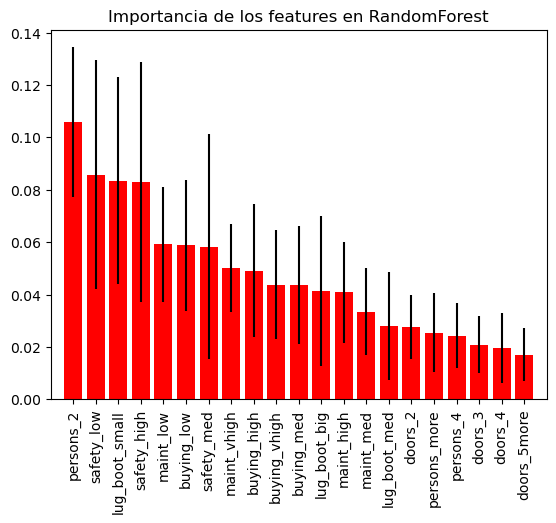

In [18]:
# opcional:asigno como indice el nombre de las features antes de ordenar 
# porque coincide el orden de las columnas de train con el de feature_importance_calc y feature_importance_calc_std
feature_importance_calc.index = X_train.columns
feature_importance_calc_std.index = X_train.columns

# ordenamos por importancia decreciente
feature_importance_calc_sort = feature_importance_calc.sort_values(ascending=False)

# ordenamos los desvíos con el orden definido por las importancias medias:
orden_definido = feature_importance_calc_sort.index
feature_importance_calc_std_sort = feature_importance_calc_std[orden_definido]

# cantidad de features:
cant_features = X_train.shape[1]
nombres_features = feature_importance_calc_sort.index

#graficamos medias y desvios como barras:
plt.figure()
plt.title("Importancia de los features en RandomForest")
plt.bar(range(cant_features), feature_importance_calc_sort, color = "r", yerr = feature_importance_calc_std_sort, align = "center")
plt.xticks(range(cant_features), nombres_features, rotation=90)
plt.xlim([-1, cant_features])
plt.show()


Ahora repetimos el cálculo de la importancia de features en otro modelo de ensamble `ExtraTreesClassifier`

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html


Cantidad de features en un árbol:  21
Importancia de features calculada:  [0.05747968 0.05444251 0.04338594 0.05312828 0.04015628 0.05110543
 0.03527408 0.05591306 0.02802829 0.01624694 0.01386423 0.01365809
 0.10470325 0.02290937 0.02357584 0.04496996 0.02895086 0.08908387
 0.085574   0.07911875 0.0584313 ]
Coinciden?  True


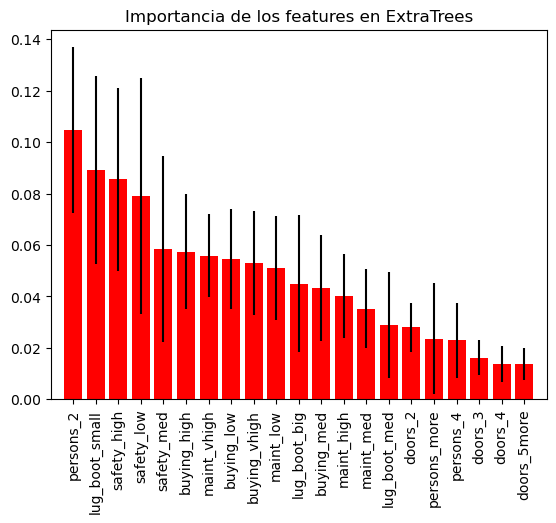

In [19]:
et = ExtraTreesClassifier(class_weight='balanced', n_jobs=-1)

et.fit(X_train, y_train)

importancias_et = et.feature_importances_

trees_feature_importance_et = [tree.feature_importances_ for tree in et.estimators_]

print("Cantidad de features en un árbol: ", len(trees_feature_importance_et[0]))

importancia_trees_base_et = pd.DataFrame(data = trees_feature_importance_et)

feature_importance_calc_et = np.mean(importancia_trees_base_et, axis = 0)

print("Importancia de features calculada: ", feature_importance_calc_et.values)

# veamos si coinciden el cálculo feature_importance_calc con el resultado de feature_importances_ como atributo del ensamble:

print("Coinciden? ", all(importancias_et == feature_importance_calc_et))

feature_importance_calc_std_et = np.std(importancia_trees_base_et, axis = 0)

#print(feature_importance_calc_std)

# opcional:asigno como indice el nombre de las features antes de ordenar 
# porque coincide el orden de las columnas de train con el de feature_importance_calc y feature_importance_calc_std
feature_importance_calc_et.index = X_train.columns
feature_importance_calc_std_et.index = X_train.columns

# oredenamos por importancia decreciente
feature_importance_calc_et_sort = feature_importance_calc_et.sort_values(ascending=False)

# ordenamos los desvíos con el orden definido por las importancias medias:
orden_definido = feature_importance_calc_et_sort.index
feature_importance_calc_std_et_sort = feature_importance_calc_std_et[orden_definido]

# cantidad de features:
cant_features = X_train.shape[1]
nombres_features = feature_importance_calc_et_sort.index

#graficamos medias y desvios como barras:
plt.figure()
plt.title("Importancia de los features en ExtraTrees")
plt.bar(range(cant_features), feature_importance_calc_et_sort, color = "r", yerr = feature_importance_calc_std_et_sort, align = "center")
plt.xticks(range(cant_features), nombres_features, rotation=90)
plt.xlim([-1, cant_features])
plt.show()


Finalmente comparemos los 3 modelos

In [20]:
importancias = pd.DataFrame(
    {'imp Árbol Decisión': dt.feature_importances_,
     'imp Random Forest': rf.feature_importances_,
     'imp Extra Trees': et.feature_importances_}).sort_values(['imp Random Forest'], ascending=False)

# (opcional) hago esto para que aparezcan los nombres de las features en lufar del índice en columns
feature_names = X_train.columns[importancias.index]
importancias.index = feature_names

importancias.plot(kind='bar')
importancias.head()

,imp Árbol Decisión,imp Random Forest,imp Extra Trees
persons_2,0.374177,0.105836,0.104703
safety_low,0.519814,0.085802,0.079119
lug_boot_small,0.000000,0.083539,0.089084
safety_high,0.000000,0.082837,0.085574
maint_low,0.000000,0.059139,0.051105
